In [ ]:
#default_exp prototypes

In [ ]:
#export
from fastai.vision.all import *
from fastai.text.all import *

from andi_unicorns.models import *
from andi_unicorns.data import *
from andi_unicorns.utils import save_model, load_model

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Prototypes
> Prototyping for different tasks

## Task 1 -- Regression

Task 1 consists on predicting the anomalous exponent of the trajectories. It is a regression task evaluated with the mean absolute error (MAE). 

The different diffusion models can have different exponents depending on whether they are subdiffusive (0 to 1) or superdiffusive (1 to 2). Hence, when building regression models specifically for each diffusion model, it is best if the output range is already limitted. 

In [ ]:
yranges = {0: (0, 1.05), 1: (0, 1.05), 2: (0, 2), 3: (1, 2.05), 4: (0, 2.05)} # Dict mapping models to yranges

### Generic model

#### Based on RNN
Using our LSTM only

In [ ]:
dim = 1
dm = 1
bs = 256
dls = get_custom_dls(target='exp', models=[dm], dim=dim, bs=bs)
my_lstm = RegLSTMLin(dim=dim, h_size=750, rnn_layers=2, in_p=0., hid_p=0.1, weight_p=1e-2, out_ps=0.3, 
                     linear_layers=[500, 200], ps=[0.4, 0.4], layer='GRU', yrange=yranges[dm])
learn = RNNLearner(dls, my_lstm, loss_func=L1LossFlat(), metrics=mae, alpha=1.)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

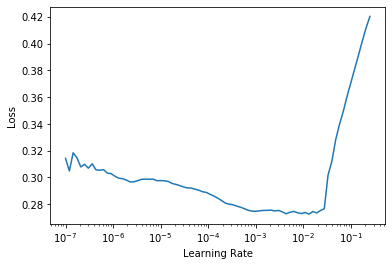

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=5e-4, wd=1e-4)

epoch,train_loss,valid_loss,mae,time
0,0.241710,0.205359,0.205359,00:44
1,0.217090,0.180383,0.180383,00:44
2,0.194166,0.161007,0.161007,00:39
3,0.175504,0.158129,0.158129,00:41
4,0.164176,0.156987,0.156987,00:45
5,0.158916,0.150794,0.150794,00:43
6,0.152152,0.150277,0.150277,00:46
7,0.152599,0.145856,0.145856,00:43
8,0.147577,0.147574,0.147574,00:46
9,0.147594,0.146104,0.146104,00:43


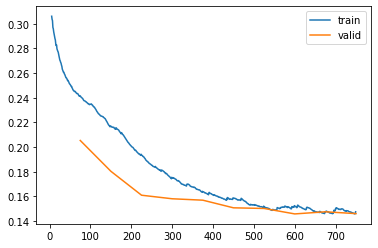

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save(f'reglstm_t{task}_dim{dim}_dm{dm}')

##### Validate the task

In [ ]:
learn.load(f'reglstm_{dim}')
validate_task([learn.model.cuda()], 1, [1])

#### Based on CNN
Using our CNN only

In [ ]:
dim = 1
dm = 0
dls = get_custom_dls(target='exp', models=[dm], dim=dim, bs=128)
cnn = CNNLin(dim, h_size=512, layers=[1, 1, 1], ks=3, out_p=0.5, stem_szs=(32, 64), 
             linear_layers=[200], ps=[0.5], yrange=yranges[dm])
learn = MyLearner(dls, cnn, loss_func=L1LossFlat(), metrics=mae)

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.9054607491852948e-06)

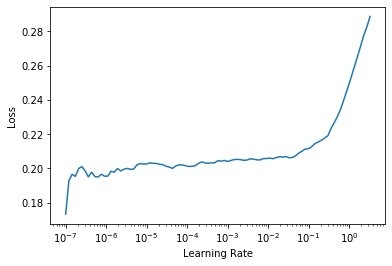

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-6, wd=1e-4)

epoch,train_loss,valid_loss,mae,time
0,0.202664,0.213439,0.213439,00:06
1,0.200738,0.214090,0.214090,00:04
2,0.200976,0.214897,0.214897,00:04
3,0.204620,0.216568,0.216568,00:04
4,0.205150,0.214465,0.214465,00:04


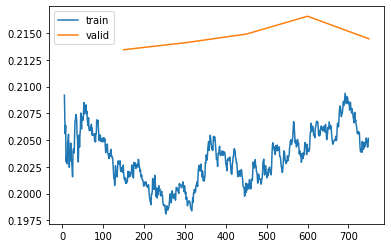

In [ ]:
learn.recorder.plot_loss()

In [ ]:
save_model(learn.model, f"cnn_dim{dim}_t{1}_dm{dm}_0")

#### Combining RNN with CNN

In [ ]:
dim = 1
dls = get_custom_dls(target='exp', dim=dim, bs=256)
model = RNNCNNClassifier(dim, vocab_sz=1, rnn_layers=2, in_p=0., rnn_p=0.1, w_p=0.01, out_p=0.3, cnn_ks=7, ps=[0.4, 0.4], linear_layers=[500, 200])
learn = RNNLearner(dls, model, loss_func=L1LossFlat(), metrics=mae)

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.0004786300996784121)

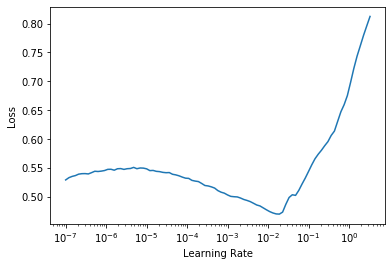

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(40, max_lr=2e-3, wd=1e-4)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
save_model(learn.model, f"rnncnn_dim{dim}_t{1}_norm")

### Model specific regressors


In [ ]:
dim = 1
bs = 256
for dm in range(5):
    for k in range(11):
        dls = get_custom_dls(target='exp', dim=dim, models=[dm], bs=bs)
        rnn = RegLSTMLin(dim=dim, h_size=750, rnn_layers=2, in_p=0., hid_p=0.1, weight_p=1e-2, out_ps=0.3, 
                             linear_layers=[500, 200], ps=[0.4, 0.4], layer='GRU', yrange=yranges[dm])
        learn = RNNLearner(dls, rnn, loss_func=L1LossFlat(), metrics=mae)
        learn.fit_one_cycle(15, max_lr=5e-4, wd=2e-4)
        
        save_model(learn.model, f"gru_dim{dim}_t{1}_dm{dm}_{k}")

epoch,train_loss,valid_loss,mae,time
0,0.288043,0.251352,0.251352,00:46
1,0.281422,0.248182,0.248182,00:42
2,0.265565,0.245462,0.245462,00:39


In [ ]:
dim = 1
bs = 128
for dm in range(5):
    for k in range(11):
        dls = get_custom_dls(target='exp', models=[dm], dim=dim, bs=128)
        cnn = CNNLin(dim, h_size=1024, layers=[1, 1, 1], ks=3, out_p=0.5, stem_szs=(32, 64), 
                     linear_layers=[200], ps=[0.5], yrange=yranges[dm])
        learn = MyLearner(dls, cnn, loss_func=L1LossFlat(), metrics=mae)
        learn.fit_one_cycle(20, max_lr=5e-3, wd=1e-4)
        
        save_model(learn.model, f"cnn_dim{dim}_t{1}_dm{dm}_{k}")

### Combining classifier with model-specific regressors

In [ ]:
class SpecificRegressor(Module):
    def __init__(self, classifier, regressors):
        store_attr('classifier,regressors')
        
    def forward(self, x):
        out_class, out_regs = self.classifier(x), self._reg_preds(x)
        return (out_class*out_regs).sum(1)
        
    def _reg_preds(self, x):
        return torch.stack([reg(x).squeeze() for reg in self.regressors], dim=1)
    
    def eval(self):
        self.classifier.eval()
        for reg in self.regressors: reg.eval()

In [ ]:
dim = 1

In [ ]:
cl_models = [load_model(f"hydra_dim{dim}_t{2}_{k}").cuda() for k in range(10)]
clf = Ensemble(cl_models, add_act=True)
regs = [Ensemble([load_model(f"cnn_dim{dim}_t{1}_dm{dm}_{k}") for k in range(10)]) for dm in range(5)]

In [ ]:
megareg = SpecificRegressor(clf, regs)

In [ ]:
megareg.eval()

In [ ]:
dl = get_validation_dl(1, bs=64, ds='train')

In [ ]:
xb, yb = dl.one_batch()

In [ ]:
pb = megareg(xb)

In [ ]:
(yb-pb).abs().mean()

tensor(0.2410, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

## Task 2 -- Classification

Task 2 consists on identifying the model with which the trajectories have been generated. The task is evaluated with F1 score (micro average). 

Here we don't have to worry about the output range. We provide an output neuron for each class, which provide the confidence that the trajectory belongs to each of those. For training, the `CrossEntropyLossFlat` already provides the last activation function for us. Nonetheless, we have to actually put the activation and take the argmax for validation. 

### Based on RNN

In [ ]:
dim = 1
dls = get_custom_dls(dim=dim, bs=128)
model = RegLSTMLin(dim, h_size=750, vocab_sz=5, rnn_layers=2, in_p=0., hid_p=0.1, weight_p=0.01, 
                   out_ps=0.3, linear_layers=[500], ps=[0.4], layer='GRU', act=False, norm=True)
learn = RNNLearner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=custom_f1)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.02290867641568184)

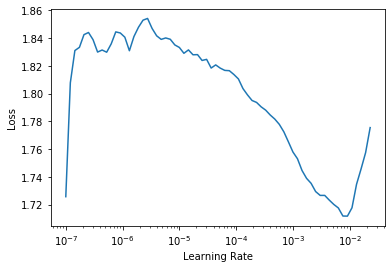

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(25, max_lr=1e-3, wd=2e-4)

epoch,train_loss,valid_loss,custom_f1,time
0,1.319991,1.337057,0.448915,03:22
1,1.019266,1.102618,0.565168,03:28
2,0.837142,1.008621,0.621064,03:45
3,0.727241,0.838847,0.672411,03:52
4,0.660354,0.757626,0.712517,03:23
5,0.623593,0.692155,0.715623,03:26
6,0.508775,0.606187,0.756386,03:24
7,0.536550,1.024291,0.584062,03:18
8,0.615358,0.507797,0.790150,03:28
9,0.879129,0.673317,0.723189,03:46


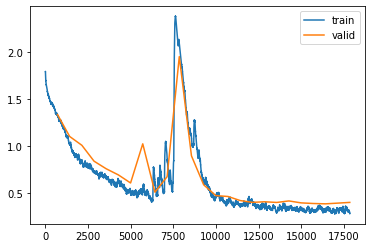

In [ ]:
learn.recorder.plot_loss()

In [ ]:
save_model(learn.model, f"gru_dim{dim}_t{2}_5")

In [ ]:
for k in range(6, 8):
    dim = 1
    dls = get_custom_dls(dim=dim, bs=128)
    model = RegLSTMLin(dim, h_size=750, vocab_sz=5, rnn_layers=2, in_p=0., hid_p=0.1, weight_p=0.01, 
                       out_ps=0.3, linear_layers=[500], ps=[0.4], layer='GRU', act=False)
    learn = RNNLearner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=custom_f1)
    learn.fit_one_cycle(25, max_lr=1e-3, wd=2e-4)
    save_model(learn.model, f"gru_dim{dim}_t{2}_{k}")

epoch,train_loss,valid_loss,custom_f1,time
0,1.219076,1.199917,0.466760,03:18
1,1.081885,1.061100,0.534946,03:21
2,0.852475,0.871407,0.634185,03:21
3,0.651514,0.729453,0.730143,03:24
4,0.537529,0.759749,0.726382,03:16
5,0.504857,0.589917,0.767538,03:19
6,0.481873,0.538592,0.806246,03:19
7,0.405866,0.579330,0.799598,03:21
8,0.416365,0.514744,0.813900,03:22
9,0.399542,0.538474,0.816174,03:20


epoch,train_loss,valid_loss,custom_f1,time
0,1.223641,1.203210,0.464223,03:20
1,1.068416,1.083653,0.518632,03:17
2,0.854043,0.879041,0.628280,03:20
3,0.579207,0.722268,0.734167,03:26
4,1.213633,1.176993,0.514783,03:22
5,0.957746,0.815483,0.637859,03:10
6,0.827949,0.759975,0.692530,03:16
7,0.749119,0.836513,0.656578,03:21
8,0.686351,0.618320,0.731237,03:25
9,0.670491,0.628908,0.732680,03:22


### Based on CNN

In [ ]:
dim = 1
dls = get_1vall_dls()
# dls = get_custom_dls(target='model', dim=dim, bs=256)
# dls = get_discriminative_dls(2, bs=128)
model = CNNLin(dim, vocab_sz=2, ks=3, out_p=0.5, linear_layers=[200], ps=[0.5], act=False)
learn = MyLearner(dls, model, loss_func=CrossEntropyLossFlat(weight=tensor([2., 1.]).cuda()), metrics=partial(custom_f1, avg='binary'))

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

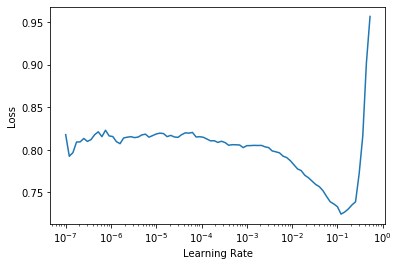

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, max_lr=5e-8, wd=1e-4)

epoch,train_loss,valid_loss,custom_f1,time
0,0.162888,0.204413,0.676031,00:17
1,0.157088,0.182137,0.674611,00:17
2,0.155409,0.182397,0.681415,00:17
3,0.157977,0.209608,0.686366,00:17
4,0.142345,0.179768,0.697007,00:17


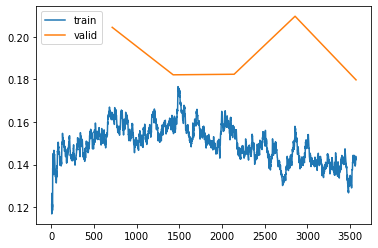

In [ ]:
learn.recorder.plot_loss()

In [ ]:
save_model(learn.model, f"cnn_dim{dim}_t{2}_1vall")

### Combining RNN with CNN

In [ ]:
dim = 1
dls = get_custom_dls(target='model', dim=dim, bs=256)
rnn_cnn = RNNCNNClassifier(dim, vocab_sz=5, rnn_layers=2, in_p=0., rnn_p=0.1, w_p=0.01, out_p=0.3, cnn_h=1024, linear_layers=[500, 200], ps=[0.4, 0.4], act=False)
learn = RNNLearner(dls, rnn_cnn, loss_func=CrossEntropyLossFlat(), metrics=custom_f1)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(40, max_lr=2e-3, wd=1e-4)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
save_model(learn.model, f"rnncnn_dim{dim}_t{2}_norm")

In [ ]:
validate_task([learn.model], 2, [1], act=True)

In [ ]:
for k in range(5):
    dim = 1
    dls = get_custom_dls(target='model', dim=dim, bs=256)
    rnn_cnn = RNNCNNClassifier(dim, vocab_sz=5, rnn_layers=2, in_p=0., rnn_p=0.1, w_p=0.01, out_p=0.3, cnn_h=1024, linear_layers=[500, 200], ps=[0.4, 0.4], act=False)
    learn = RNNLearner(dls, rnn_cnn, loss_func=CrossEntropyLossFlat(), metrics=custom_f1)
    learn.fit_one_cycle(40, max_lr=2e-3, wd=1e-4)
    save_model(learn.model, f"rnncnn_dim{dim}_t{2}_{k}")

#### Hydra

In [ ]:
dim = 1
m_id = 6
# dls = get_custom_dls(target='model', dim=dim, bs=128)
dls = get_discriminative_dls(2, bs=256)
cnn = load_model(f"cnn_dim{dim}_t{2}_ks3_{m_id}")
rnn = load_model(f"gru_dim{dim}_t{2}_{m_id}")
hydra = Hydra([rnn, cnn], vocab_sz=5, out_ps=0.4, linear_layers=[200], ps=[0.4], act=False)

In [ ]:
learn = MyLearner(dls, hydra, loss_func=CrossEntropyLossFlat(), metrics=custom_f1)

In [ ]:
learn.unfreeze()

In [ ]:
for block in learn.model.blocks: block.train()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0006918309954926372)

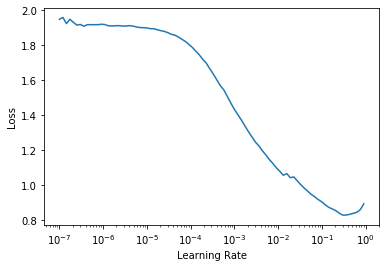

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=(1e-6, 1e-6, 1e-4), wd=5e-4)

epoch,train_loss,valid_loss,custom_f1,time
0,0.296062,0.348653,0.853500,00:22
1,0.311531,0.343381,0.856500,00:20
2,0.326548,0.344243,0.856500,00:19
3,0.311503,0.342688,0.856000,00:19
4,0.313457,0.342822,0.851500,00:19


In [ ]:
save_model(learn.model, f"hydra_dim{dim}_t{2}_13")